<a href="https://colab.research.google.com/github/Dhavalkumar510/Uptrail/blob/main/Week_3_CPSWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------------------
# Importing Libraries
-------------------

Analysis started at: 2025-10-08T23:04:52.970860

Columns in dataset: ['user_id', 'age', 'gender', 'signup_date', 'last_active_date', 'country', 'subscription_type', 'average_watch_hours', 'mobile_app_usage_pct', 'complaints_raised', 'received_promotions', 'referred_by_friend', 'is_churned', 'monthly_fee']

Initial shape: (1500, 14)

Head (first 5 rows):


,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee
0,1001.0,56.0,Other,02-04-25,13-07-25,France,Standard,42.6,77.4,1.0,No,No,1.0,10.99
1,1002.0,69.0,Male,02-01-23,13-07-25,India,Basic,65.3,98.0,4.0,No,Yes,1.0,5.99
2,1003.0,46.0,Male,21-08-22,13-07-25,UK,Premium,40.1,47.8,0.0,No,Yes,1.0,13.99
3,1004.0,32.0,Other,14-09-23,13-07-25,Germany,Premium,5.8,53.2,1.0,Yes,Yes,1.0,13.99
4,1005.0,60.0,Female,29-07-23,13-07-25,India,Standard,32.7,16.8,5.0,No,Yes,0.0,9.99



Detected columns:
 signup: signup_date
 last active: last_active_date
 churn: is_churned
 promotion: received_promotions
 average watch: average_watch_hours
 mobile usage: mobile_app_usage_pct
 monthly fee: monthly_fee
 user id: user_id

Final features shape: (1500, 20) Target distribution:
 is_churned
0    0.766
1    0.234
Name: proportion, dtype: float64


/tmp/ipython-input-1151665637.py:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[signup_col] = pd.to_datetime(df[signup_col], errors='coerce')



=== Churn Model Evaluation ===
Confusion matrix:
 [[230   0]
 [ 70   0]]
Precision: 0.000, Recall: 0.000, F1: 0.000, AUC: 0.459


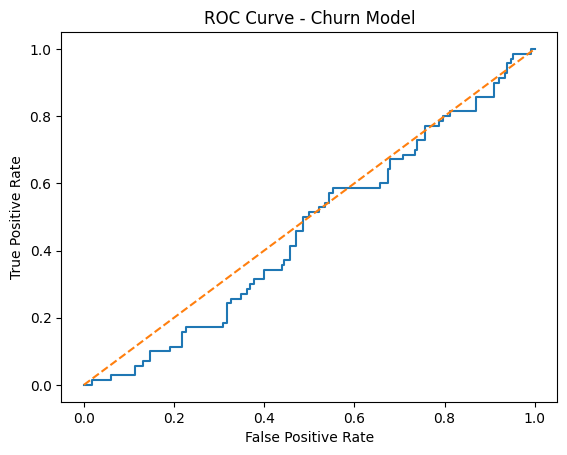


Top features by absolute coefficient (churn model):


,0
watch_per_fee_ratio,-0.261300
average_watch_hours,0.233544
gender_Other,-0.146479
monthly_fee,-0.142041
gender_Male,-0.126663
country_India,0.109485
received_promotions_Yes,-0.092567
promotion_flag,-0.092567
country_UK,0.087489
heavy_mobile_user,-0.083792




📊 BUSINESS QUESTIONS & INSIGHTS

1) Promotion vs churn rate (mean churn, count):
                     mean  count
promotion_flag                 
0               0.251958    766
1               0.215259    734
Conclusion: users with promotion_flag=1 are LESS likely to churn after promotion (difference = -0.037)

2) Mean watch hours by churn status:
 is_churned
0    39.965709
1    39.703704
Name: average_watch_hours, dtype: float64
T-test between churned vs retained watch hours: t=-0.186, p=0.8527
Conclusion: churned users WATCH LESS on average.

3) Heavy mobile user churn rates:
                        mean  count
heavy_mobile_user                 
0                  0.230694   1023
1                  0.241090    477
Conclusion: Mobile-dominant users MORE likely to churn.

4) Top 3 churn predictors (model):
  - watch_per_fee_ratio: reduces churn (coef = -0.2613)
  - average_watch_hours: increases churn (coef = 0.2335)
  - gender_Other: reduces churn (coef = -0.1465)

5) Retention rec

,0
watch_per_fee_ratio,24.609944
monthly_fee,11.515870
subscription_type_Standard,2.434575
mobile_app_usage_pct,-0.517453
heavy_mobile_user,0.513440
tenure_days,-0.477478
gender_Male,-0.361822
country_USA,0.351707
country_UK,0.332635
gender_Other,-0.317741



Done.


In [106]:
# Clean, focused analysis script for business questions
# Purpose: Load the provided CSV, prepare data, answer core business questions for retention:
#  - Do promotions reduce churn?
#  - Does watch time impact churn?
#  - Are mobile-dominant users more likely to cancel?
# Also: train simple predictive models (Logistic for churn, Linear for watch time)
# Timestamp (initial period): printed below

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    mean_squared_error, r2_score
)
from scipy.stats import ttest_ind

# === Load data ===
path = "/content/streamworks_user_data.csv"
df = pd.read_csv(path)

print("Analysis started at:", datetime.now().isoformat())
print("\nColumns in dataset:", df.columns.tolist())

# === Basic inspection ===
print("\nInitial shape:", df.shape)
print("\nHead (first 5 rows):")
display(df.head())

# Normalize column names for robustness
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# === Identify common column names (robust lookup) ===
def find_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

signup_col = find_col(['signup_date', 'signup'])
last_active_col = find_col(['last_active_date', 'last_active', 'lastseen', 'last_seen_date'])
churn_col = find_col(['is_churned', 'churned', 'is_churn', 'churn', 'cancelled', 'is_cancelled'])
promo_col = find_col(['promotion_received', 'received_promotions', 'promotion_received', 'promotion', 'received_promotion'])
watch_col = find_col(['average_watch_hours', 'avg_watch_hours', 'watch_hours', 'average_watch_time'])
mobile_col = find_col(['mobile_app_usage_pct', 'mobile_usage_pct', 'mobile_app_pct', 'mobile_usage'])
monthly_fee_col = find_col(['monthly_fee', 'subscription_fee', 'price', 'monthly_price'])
user_id_col = find_col(['user_id', 'id', 'customer_id'])

print("\nDetected columns:")
print(" signup:", signup_col)
print(" last active:", last_active_col)
print(" churn:", churn_col)
print(" promotion:", promo_col)
print(" average watch:", watch_col)
print(" mobile usage:", mobile_col)
print(" monthly fee:", monthly_fee_col)
print(" user id:", user_id_col)

# === Create/clean target and basic features ===
# Convert dates if present
if signup_col and last_active_col:
    df[signup_col] = pd.to_datetime(df[signup_col], errors='coerce')
    df[last_active_col] = pd.to_datetime(df[last_active_col], errors='coerce')
    df['tenure_days'] = (df[last_active_col] - df[signup_col]).dt.days
else:
    df['tenure_days'] = np.nan

# Standardise churn to binary 0/1 if present; if not present, try to create a proxy (tenure_days very small -> churn)
if churn_col:
    # map common truthy/falsy values to 1/0
    df[churn_col] = df[churn_col].replace({True:1, False:0, 'Yes':1, 'No':0, 'yes':1, 'no':0, 'Y':1, 'N':0})
    df[churn_col] = pd.to_numeric(df[churn_col], errors='coerce').fillna(0).astype(int)
else:
    # proxy: churn = tenure_days <= 7 (very short) as a fallback
    df['is_churned'] = (df['tenure_days'] <= 7).astype(int)
    churn_col = 'is_churned'

# Fill numeric missing values with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical missing values with mode
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for c in cat_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# Drop identifier columns to avoid leakage / odd feature importance
if user_id_col:
    df.drop(columns=[user_id_col], inplace=True, errors='ignore')

# Create a promotion binary column if possible
if promo_col:
    df['promotion_flag'] = df[promo_col].astype(str).str.lower().map(lambda x: 1 if x in ['1','true','yes','y','received','received_promotions','received','1.0'] else 0)
else:
    # try to detect a 'received_promotions' or similar column with 0/1 values
    df['promotion_flag'] = 0

# Create mobile-dominant user flag
if mobile_col:
    df['heavy_mobile_user'] = (df[mobile_col] > 70).astype(int)
else:
    df['heavy_mobile_user'] = 0

# Create watch_per_fee_ratio if possible
if watch_col and monthly_fee_col:
    # protect divide by zero
    df[monthly_fee_col] = df[monthly_fee_col].replace(0, np.nan).fillna(df[monthly_fee_col].median())
    df['watch_per_fee_ratio'] = df[watch_col] / df[monthly_fee_col]
else:
    df['watch_per_fee_ratio'] = 0.0

# Ensure main watch column numeric
if watch_col:
    df[watch_col] = pd.to_numeric(df[watch_col], errors='coerce').fillna(df[watch_col].median())
else:
    # create synthetic watch column if completely missing (will be constant -> limited info)
    df['average_watch_hours'] = df.get('average_watch_hours', 0.0)
    watch_col = 'average_watch_hours'

# Drop raw date columns (we have tenure_days)
if signup_col:
    df.drop(columns=[signup_col], inplace=True, errors='ignore')
if last_active_col:
    df.drop(columns=[last_active_col], inplace=True, errors='ignore')

# === Prepare features for modelling ===
target = churn_col
X = df.drop(columns=[target], errors='ignore')
# Convert remaining object columns to dummies
X = pd.get_dummies(X, drop_first=True)
# Align types
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

y = df[target].astype(int)

print("\nFinal features shape:", X.shape, "Target distribution:\n", y.value_counts(normalize=True))

# === Split for churn model ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_class = logreg.predict(X_test_scaled)
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]

# === Evaluation for churn ===
cm = confusion_matrix(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, zero_division=0)
recall = recall_score(y_test, y_pred_class, zero_division=0)
f1 = f1_score(y_test, y_pred_class, zero_division=0)
auc_score = roc_auc_score(y_test, y_pred_prob)

print("\n=== Churn Model Evaluation ===")
print("Confusion matrix:\n", cm)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {auc_score:.3f}")

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Model')
plt.show()

# Feature importance (coefficients)
feat_imp = pd.Series(logreg.coef_[0], index=X.columns).sort_values(key=lambda x: x.abs(), ascending=False)
# Remove any potential id-like columns from importance view
feat_imp = feat_imp[~feat_imp.index.str.contains('user_id|id_|id$')]

print("\nTop features by absolute coefficient (churn model):")
display(feat_imp.head(15))

# === Business question checks (descriptive, independent from model) ===
print("\n\n==============================")
print("📊 BUSINESS QUESTIONS & INSIGHTS")
print("==============================")

# 1) Do users who receive promotions churn less?
if 'promotion_flag' in df.columns:
    promo_churn = df.groupby('promotion_flag')[target].agg(['mean','count'])
    print("\n1) Promotion vs churn rate (mean churn, count):\n", promo_churn)
    if promo_churn.shape[0] >= 2:
        promo_effect = promo_churn['mean'].iloc[1] - promo_churn['mean'].iloc[0]
        conclusion = "LESS likely to churn after promotion" if promo_effect < 0 else "MORE likely to churn after promotion"
        print(f"Conclusion: users with promotion_flag=1 are {conclusion} (difference = {promo_effect:.3f})")
else:
    print("\n1) No promotion data available.")

# 2) Does watch time impact churn likelihood?
if watch_col in df.columns:
    mean_churn_watch = df.groupby(target)[watch_col].mean()
    print("\n2) Mean watch hours by churn status:\n", mean_churn_watch)
    churn_watch = df[df[target]==1][watch_col]
    retained_watch = df[df[target]==0][watch_col]
    try:
        t_stat, p_val = ttest_ind(churn_watch, retained_watch, equal_var=False)
        print(f"T-test between churned vs retained watch hours: t={t_stat:.3f}, p={p_val:.4f}")
    except Exception as e:
        print("T-test failed:", e)
    if mean_churn_watch.loc[1] < mean_churn_watch.loc[0]:
        print("Conclusion: churned users WATCH LESS on average.")
    else:
        print("Conclusion: churned users WATCH MORE on average.")
else:
    print("\n2) No watch-time column identified.")

# 3) Are mobile-dominant users more likely to cancel?
if 'heavy_mobile_user' in df.columns:
    mobile_churn = df.groupby('heavy_mobile_user')[target].agg(['mean','count'])
    print("\n3) Heavy mobile user churn rates:\n", mobile_churn)
    if mobile_churn.shape[0] >= 2:
        delta = mobile_churn['mean'].iloc[1] - mobile_churn['mean'].iloc[0]
        print("Conclusion:", "Mobile-dominant users MORE likely to churn." if delta>0 else "Mobile-dominant users LESS likely to churn.")
else:
    print("\n3) No mobile usage data available.")

# 4) Top predictors from the logistic model (excluding identifiers)
top3 = feat_imp.head(3)
print("\n4) Top 3 churn predictors (model):")
for name, coef in top3.items():
    trend = "increases churn" if coef > 0 else "reduces churn"
    print(f"  - {name}: {trend} (coef = {coef:.4f})")

# 5) Retention recommendation
print("\n5) Retention recommendation: prioritize users with high model score and features like:")
print("   ", list(top3.index))

# === Watch-time regression (Linear) to find factors affecting watch time ===
if watch_col in df.columns:
    y_watch = df[watch_col]
    X_watch = df.drop(columns=[watch_col, target], errors='ignore')
    X_watch = pd.get_dummies(X_watch, drop_first=True).replace([np.inf, -np.inf], np.nan).fillna(0)
    # remove columns that are constant
    X_watch = X_watch.loc[:, X_watch.apply(pd.Series.nunique) > 1]
    Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_watch, y_watch, test_size=0.2, random_state=42)
    scaler_w = StandardScaler()
    Xw_train_s = scaler_w.fit_transform(Xw_train)
    Xw_test_s = scaler_w.transform(Xw_test)
    linreg = LinearRegression()
    linreg.fit(Xw_train_s, yw_train)
    y_pred_w = linreg.predict(Xw_test_s)
    r2 = r2_score(yw_test, y_pred_w)
    rmse = np.sqrt(mean_squared_error(yw_test, y_pred_w))
    print(f"\n6) Watch-time model performance: R2 = {r2:.3f}, RMSE = {rmse:.3f}")
    coef_watch = pd.Series(linreg.coef_, index=X_watch.columns).sort_values(key=lambda x: x.abs(), ascending=False)
    print("\nTop features affecting watch time:")
    display(coef_watch.head(10))
else:
    print("\n6) Cannot model watch time (no watch column).")

print("\n==============================\nDone.")

# End of script



In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_score, recall_score, f1_score, mean_squared_error, r2_score
)
from scipy.stats import chi2_contingency, ttest_ind
from pandas import get_dummies


-------------------
# Loading and Exploring the Data
-------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB
None
           user_id

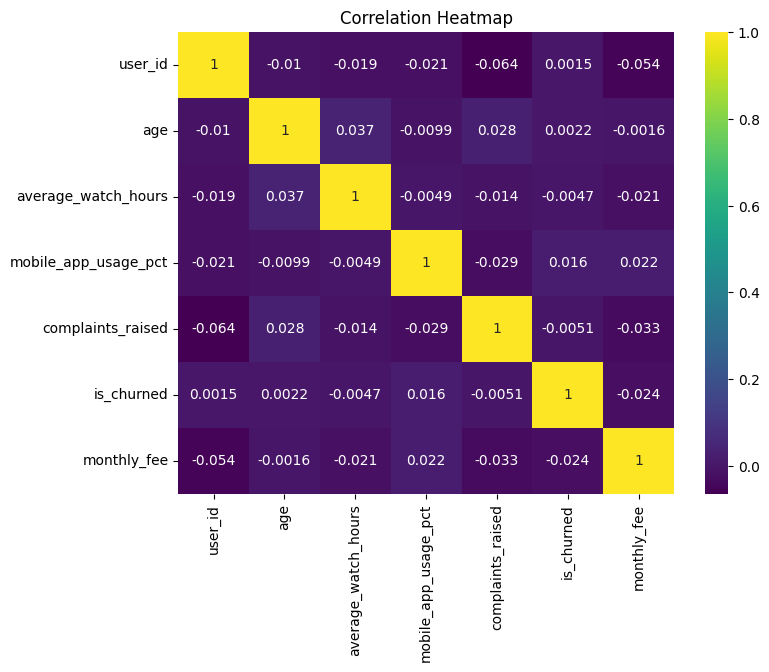

In [87]:
df = pd.read_csv("/content/streamworks_user_data.csv")

print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.head())

# Correlation heatmap for numeric columns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

 -------------------
 # Data Cleaning
 -------------------

In [89]:
# 1. Convert date columns to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_active_date'] = pd.to_datetime(df['last_active_date'])

# 2. Create tenure_days (difference between signup and last active date)
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days

# 3. Create is_loyal (True if tenure_days > 180)
df['is_loyal'] = df['tenure_days'] > 180

# 4. Handle missing values
df['age'].fillna(df['age'].median(), inplace=True)
df['gender'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['subscription_type'].fillna('Unknown', inplace=True)

# 5. Encode categorical features
label_enc = LabelEncoder()
df['gender'] = label_enc.fit_transform(df['gender'])
df['received_promotions'] = label_enc.fit_transform(df['received_promotions'])
df['referred_by_friend'] = label_enc.fit_transform(df['referred_by_friend'])
df['subscription_type'] = label_enc.fit_transform(df['subscription_type'])
df['country'] = label_enc.fit_transform(df['country'])

# 6. Double-check cleaned data
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               1498 non-null   float64       
 1   age                   1500 non-null   float64       
 2   gender                1500 non-null   int64         
 3   signup_date           1498 non-null   datetime64[ns]
 4   last_active_date      1498 non-null   datetime64[ns]
 5   country               1500 non-null   int64         
 6   subscription_type     1500 non-null   int64         
 7   average_watch_hours   1496 non-null   float64       
 8   mobile_app_usage_pct  1498 non-null   float64       
 9   complaints_raised     1497 non-null   float64       
 10  received_promotions   1500 non-null   int64         
 11  referred_by_friend    1500 non-null   int64         
 12  is_churned            1499 non-null   float64       
 13  monthly_fee       

/tmp/ipython-input-4209983370.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['signup_date'] = pd.to_datetime(df['signup_date'])
/tmp/ipython-input-4209983370.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/tmp/ipython-input-4209983370.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through

In [90]:
df.isnull().sum()

,0
user_id,2
age,0
gender,0
signup_date,2
last_active_date,2
country,0
subscription_type,0
average_watch_hours,4
mobile_app_usage_pct,2
complaints_raised,3


In [91]:
df.fillna({
    'signup_date': df['signup_date'].mode()[0],
    'last_active_date': df['last_active_date'].mode()[0],
    'user_id': 'Unknown',
    'age': df['age'].median(),
    'average_watch_hours': df['average_watch_hours'].mean(),
    'mobile_app_usage_pct': 0,
    'complaints_raised': 0,
    'is_churned': 0,
    'tenure_days': df['tenure_days'].median(),
    'gender': 'Unknown',
    'country': 'Unknown',
    'subscription_type': 'Unknown'
}, inplace=True)

df['monthly_fee'] = df.groupby('subscription_type')['monthly_fee'].transform(lambda x: x.fillna(x.median()))


In [92]:
df.isnull().sum()

,0
user_id,0
age,0
gender,0
signup_date,0
last_active_date,0
country,0
subscription_type,0
average_watch_hours,0
mobile_app_usage_pct,0
complaints_raised,0


In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# ==========================
# Convert date columns to datetime
# ==========================
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_active_date'] = pd.to_datetime(df['last_active_date'])

# ==========================
# Create new features
# ==========================
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days
df['is_loyal'] = (df['tenure_days'] > 180).astype(int)
df['watch_per_fee_ratio'] = df['average_watch_hours'] / df['monthly_fee']
df['heavy_mobile_user'] = (df['mobile_app_usage_pct'] > 70).astype(int)

# ==========================
# Fill missing values (example: numeric fill with median)
# ==========================
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill categorical columns with mode
categorical_cols = ['gender', 'country', 'subscription_type', 'received_promotions']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# ==========================
# Encode categorical features using LabelEncoder
# ==========================
le = LabelEncoder()
for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

# ==========================
# Scale numeric features (optional but useful)
# ==========================
scaler = MinMaxScaler()
df[['average_watch_hours', 'monthly_fee', 'tenure_days']] = scaler.fit_transform(
    df[['average_watch_hours', 'monthly_fee', 'tenure_days']]
)


In [94]:
df.shape

(1500, 18)

In [95]:
df.head()

,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee,tenure_days,is_loyal,watch_per_fee_ratio,heavy_mobile_user
0,1001.0,56.0,2,2025-02-04,2025-07-13,1,2,0.530227,77.4,1.0,0,0,1.0,0.555556,0.214286,0,3.876251,1
1,1002.0,69.0,1,2023-02-01,2025-07-13,3,0,0.816121,98.0,4.0,0,1,1.0,0.000000,0.728291,1,10.901503,1
2,1003.0,46.0,1,2022-08-21,2025-07-13,4,1,0.498741,47.8,0.0,0,1,1.0,0.888889,0.843137,1,2.866333,0
3,1004.0,32.0,2,2023-09-14,2025-07-13,2,1,0.066751,53.2,1.0,1,1,1.0,0.888889,0.570728,1,0.414582,0
4,1005.0,60.0,0,2023-07-29,2025-07-13,3,2,0.405542,16.8,5.0,0,1,0.0,0.444444,0.603641,1,3.273273,0


In [96]:
df.isnull().sum()

,0
user_id,0
age,0
gender,0
signup_date,0
last_active_date,0
country,0
subscription_type,0
average_watch_hours,0
mobile_app_usage_pct,0
complaints_raised,0


In [97]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# ==========================
# Convert date columns to datetime
# ==========================
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_active_date'] = pd.to_datetime(df['last_active_date'])

# ==========================
# 1️⃣ Create new features
# ==========================
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days
df['is_loyal'] = (df['tenure_days'] > 180).astype(int)
df['watch_per_fee_ratio'] = df['average_watch_hours'] / df['monthly_fee']
df['heavy_mobile_user'] = (df['mobile_app_usage_pct'] > 70).astype(int)

# ==========================
# 2️⃣ Handle missing values
# ==========================
# Numeric columns: fill with median
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Categorical columns: fill with mode
categorical_cols = ['gender', 'country', 'subscription_type', 'received_promotions']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# ==========================
# 3️⃣ Encode categorical features
# ==========================
le = LabelEncoder()
for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])  # Label encoding (binary/ordinal)

# Example: one-hot encoding for subscription_type if needed
# df = pd.get_dummies(df, columns=['subscription_type'], drop_first=True)

# ==========================
# 4️⃣ Scale numeric variables (normalization)
# ==========================
scaler = MinMaxScaler()
df[['average_watch_hours', 'monthly_fee', 'tenure_days']] = scaler.fit_transform(
    df[['average_watch_hours', 'monthly_fee', 'tenure_days']]
)

# ==========================
# 5️⃣ Discretisation / Binning
# ==========================
df['age_group'] = pd.cut(df['age'], bins=[0,18,30,45,60,100], labels=['Teen','Young','Adult','Middle','Senior'])
df['watch_time_group'] = pd.cut(df['average_watch_hours'], bins=3, labels=['Low','Medium','High'])

# ==========================
# 6️⃣ Interaction features
# ==========================
df['promo_low_watch'] = np.where(
    (df['received_promotions'] == 1) & (df['average_watch_hours'] < df['average_watch_hours'].mean()),
    1, 0
)

# ==========================
# 7️⃣ Feature selection
# ==========================
# Drop redundant / low-variance columns
df.drop(['signup_date', 'last_active_date'], axis=1, inplace=True)


In [98]:
df.shape

(1500, 19)

In [99]:
df.head(10)

,user_id,age,gender,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee,tenure_days,is_loyal,watch_per_fee_ratio,heavy_mobile_user,age_group,watch_time_group,promo_low_watch
0,1001.0,56.0,2,1,2,0.530227,77.4,1.0,0,0,1.0,0.555556,0.214286,0,0.954408,1,Middle,Medium,0
1,1002.0,69.0,1,3,0,0.816121,98.0,4.0,0,1,1.0,0.000000,0.728291,1,inf,1,Senior,High,0
2,1003.0,46.0,1,4,1,0.498741,47.8,0.0,0,1,1.0,0.888889,0.843137,1,0.561083,0,Middle,Medium,0
3,1004.0,32.0,2,2,1,0.066751,53.2,1.0,1,1,1.0,0.888889,0.570728,1,0.075094,0,Adult,Low,1
4,1005.0,60.0,0,3,2,0.405542,16.8,5.0,0,1,0.0,0.444444,0.603641,1,0.912469,0,Middle,Medium,0
5,1006.0,25.0,1,5,1,0.497481,24.7,1.0,0,1,0.0,0.888889,0.627451,1,0.559666,0,Young,Medium,0
6,1007.0,38.0,1,4,1,0.721662,83.9,0.0,0,1,0.0,1.000000,0.718487,1,0.721662,1,Adult,High,0
7,1008.0,56.0,1,2,1,0.107053,35.6,5.0,0,1,0.0,1.000000,0.758403,1,0.107053,0,Middle,Low,0
8,1009.0,36.0,2,4,2,0.139798,82.7,1.0,0,1,0.0,0.444444,0.133754,0,0.314547,1,Adult,Low,0
9,1010.0,40.0,1,1,0,0.264484,70.9,5.0,1,1,0.0,0.111111,0.359944,1,2.380353,1,Adult,Low,1


=== Chi-square Tests ===
gender vs is_churned: chi2=7.478, p-value=0.0581
received_promotions vs is_churned: chi2=12.219, p-value=0.0022
referred_by_friend vs is_churned: chi2=1.717, p-value=0.4238

=== T-test for Watch Hours ===
T-statistic=-0.186, p-value=0.8527


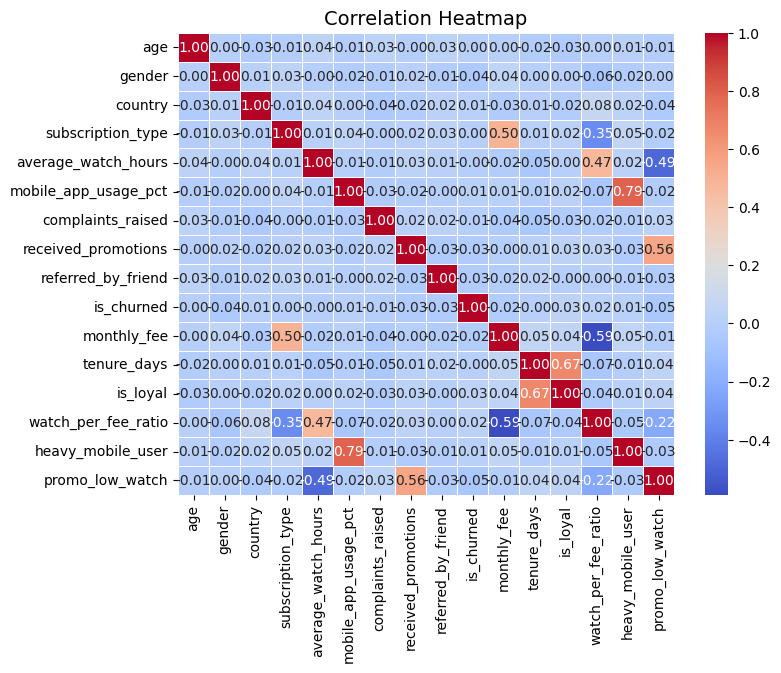

/tmp/ipython-input-1756428872.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=numeric_col, data=df, palette=["green","red"])


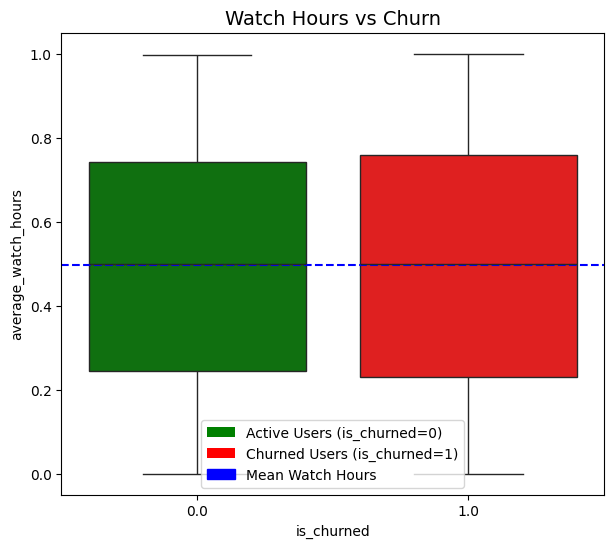

/tmp/ipython-input-1756428872.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set3")


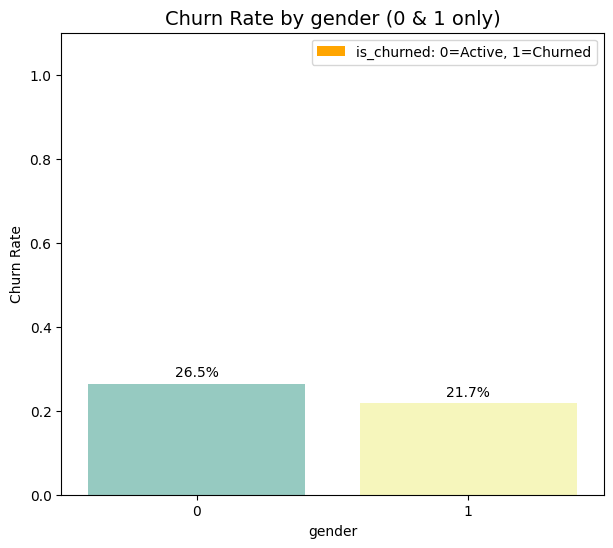

/tmp/ipython-input-1756428872.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set3")


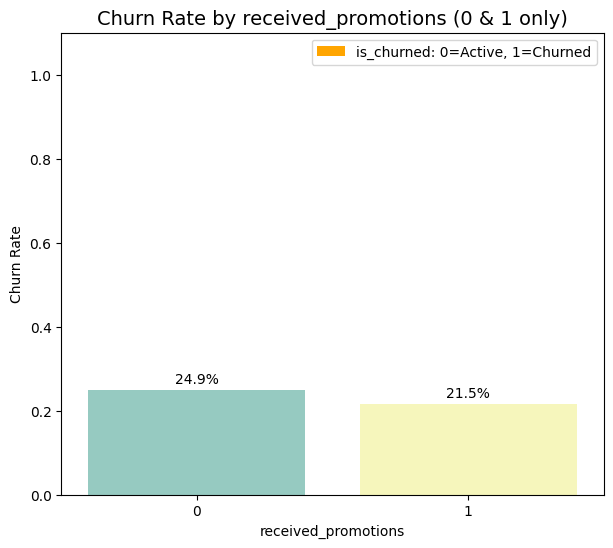

/tmp/ipython-input-1756428872.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set3")


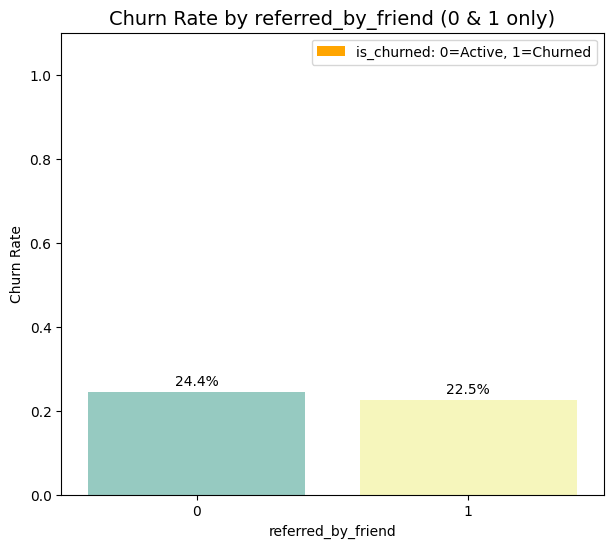

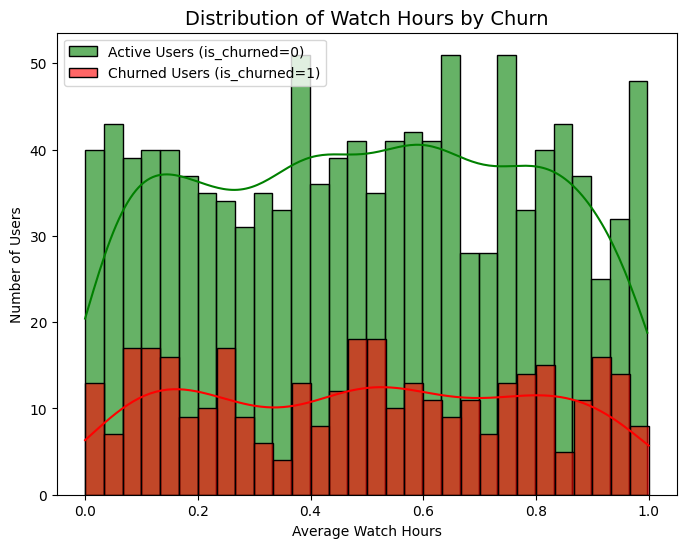

In [100]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ==========================
# Parameters
# ==========================
categorical_cols = ['gender', 'received_promotions', 'referred_by_friend']
numeric_col = 'average_watch_hours'
target_col = 'is_churned'

# ==========================
# 1️⃣ Chi-square tests
# ==========================
print("=== Chi-square Tests ===")
for col in categorical_cols:
    if col in df.columns:
        cont = pd.crosstab(df[col], df[target_col])
        chi2, p, _, _ = chi2_contingency(cont)
        print(f"{col} vs {target_col}: chi2={chi2:.3f}, p-value={p:.4f}")

# ==========================
# 2️⃣ T-test for watch hours
# ==========================
if numeric_col in df.columns:
    churned = df[df[target_col] == 1][numeric_col]
    retained = df[df[target_col] == 0][numeric_col]
    t_stat, p_val = ttest_ind(churned, retained, equal_var=False)
    print("\n=== T-test for Watch Hours ===")
    print(f"T-statistic={t_stat:.3f}, p-value={p_val:.4f}")

# ==========================
# 3️⃣ Correlation analysis
# ==========================
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

# ==========================
# 4️⃣ Boxplot: Watch hours vs churn
# ==========================
plt.figure(figsize=(7,6))
sns.boxplot(x=target_col, y=numeric_col, data=df, palette=["green","red"])
plt.title('Watch Hours vs Churn', fontsize=14)
plt.axhline(df[numeric_col].mean(), color='blue', linestyle='--', label='Mean Watch Hours')

# Legend specific to this boxplot
plt.legend(handles=[
    Patch(facecolor='green', label='Active Users (is_churned=0)'),
    Patch(facecolor='red', label='Churned Users (is_churned=1)'),
    Patch(facecolor='blue', label='Mean Watch Hours', edgecolor='blue')
])
plt.show()
# ==========================
# 5️⃣ Barplots: Categorical vs churn (only 0 and 1 categories)
# ==========================
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(7,6))

        # Keep only 0 and 1 categories automatically
        churn_rate = df[df[col].isin([0,1])].groupby(col)[target_col].mean()

        ax = sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set3")
        plt.title(f'Churn Rate by {col} (0 & 1 only)', fontsize=14)
        plt.ylabel('Churn Rate')

        # Annotate percentages
        for i, val in enumerate(churn_rate.values):
            ax.text(i, val + 0.01, f"{val*100:.1f}%", ha='center', va='bottom', fontsize=10)

        # Legend
        plt.legend([Patch(facecolor='orange')], [f"{target_col}: 0=Active, 1=Churned"])
        plt.ylim(0, 1.1)

        # Set x-ticks for available categories (0 and 1)
        ax.set_xticks(range(len(churn_rate.index)))
        ax.set_xticklabels(churn_rate.index)

        plt.show()

# ==========================
# 6️⃣ Histogram: Watch hours distribution by churn
# ==========================
plt.figure(figsize=(8,6))
bins = 30
sns.histplot(df[df[target_col]==0][numeric_col], color='green', label='Active Users (is_churned=0)', kde=True, alpha=0.6, bins=bins)
sns.histplot(df[df[target_col]==1][numeric_col], color='red', label='Churned Users (is_churned=1)', kde=True, alpha=0.6, bins=bins)
plt.title('Distribution of Watch Hours by Churn', fontsize=14)
plt.xlabel('Average Watch Hours')
plt.ylabel('Number of Users')
plt.legend()
plt.show()


In [101]:
df.columns.tolist()

['user_id',
 'age',
 'gender',
 'country',
 'subscription_type',
 'average_watch_hours',
 'mobile_app_usage_pct',
 'complaints_raised',
 'received_promotions',
 'referred_by_friend',
 'is_churned',
 'monthly_fee',
 'tenure_days',
 'is_loyal',
 'watch_per_fee_ratio',
 'heavy_mobile_user',
 'age_group',
 'watch_time_group',
 'promo_low_watch']

Data Head:
   user_id   age  gender  country  subscription_type  average_watch_hours  \
0  1001.0  56.0       2        1                  2             0.530227   
1  1002.0  69.0       1        3                  0             0.816121   
2  1003.0  46.0       1        4                  1             0.498741   
3  1004.0  32.0       2        2                  1             0.066751   
4  1005.0  60.0       0        3                  2             0.405542   

   mobile_app_usage_pct  complaints_raised  received_promotions  \
0                  77.4                1.0                    0   
1                  98.0                4.0                    0   
2                  47.8                0.0                    0   
3                  53.2                1.0                    1   
4                  16.8                5.0                    0   

   referred_by_friend  is_churned  monthly_fee  tenure_days  is_loyal  \
0                   0         1.0     0.555556     0.21

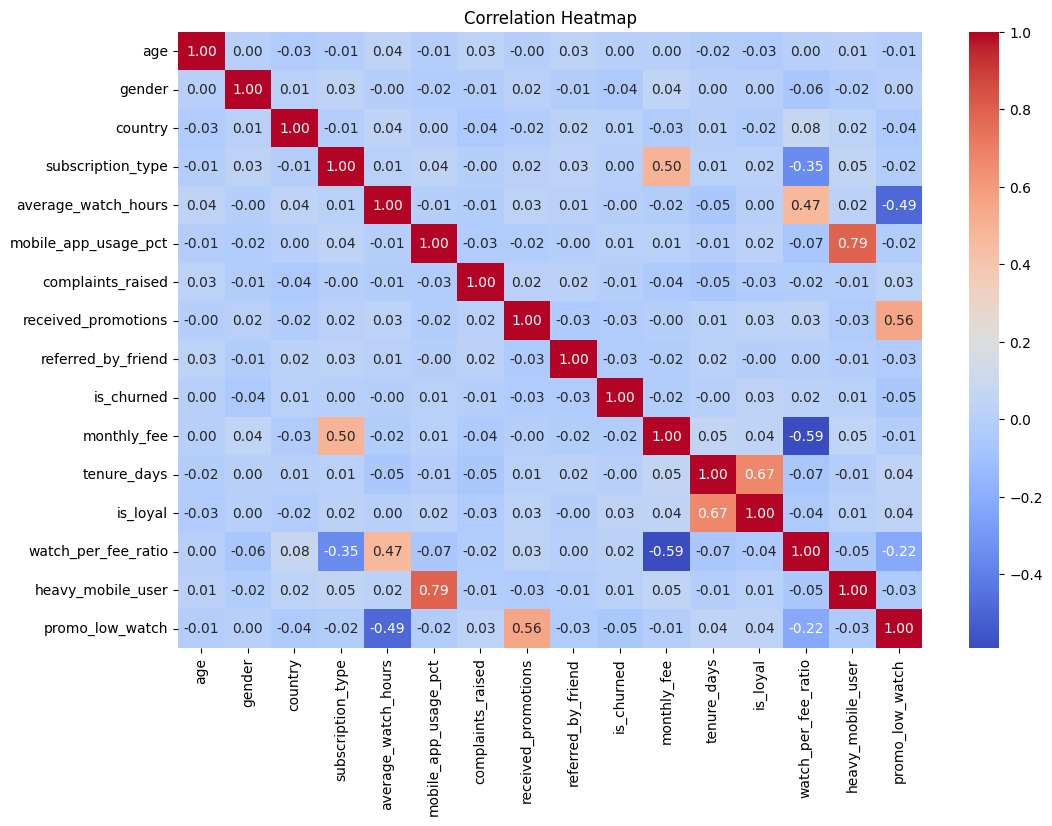

=== Logistic Regression Evaluation ===
Confusion Matrix:
 [[221   0]
 [ 79   0]]
Precision: 0.000, Recall: 0.000, F1 Score: 0.000, AUC: 0.466


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


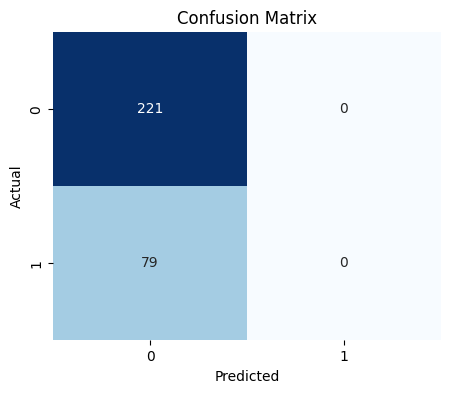

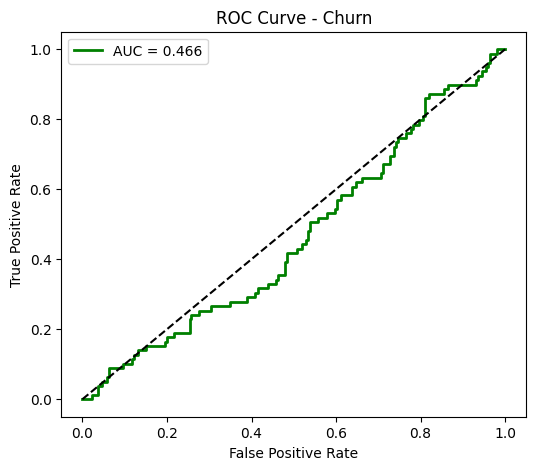

/tmp/ipython-input-1440351846.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients.head(15), x='Coefficient', y='Feature', palette="viridis")


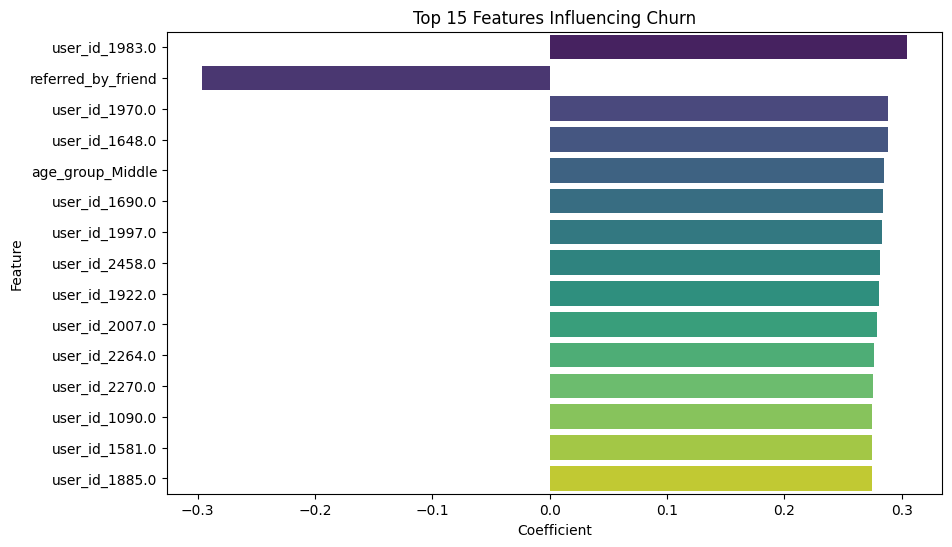


=== Linear Regression Evaluation ===
R2: 0.633, RMSE: 0.176


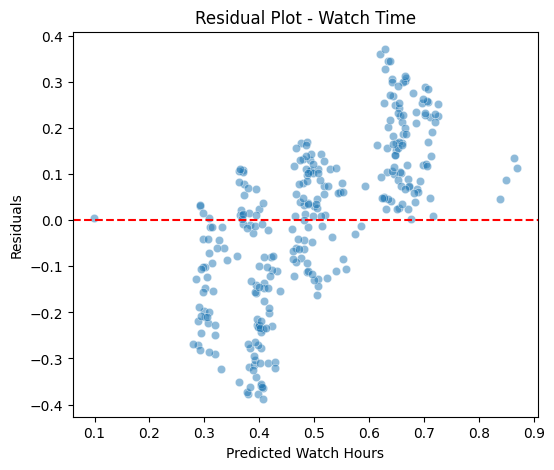

/tmp/ipython-input-1440351846.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lin_coefficients.head(15), x='Coefficient', y='Feature', palette="magma")


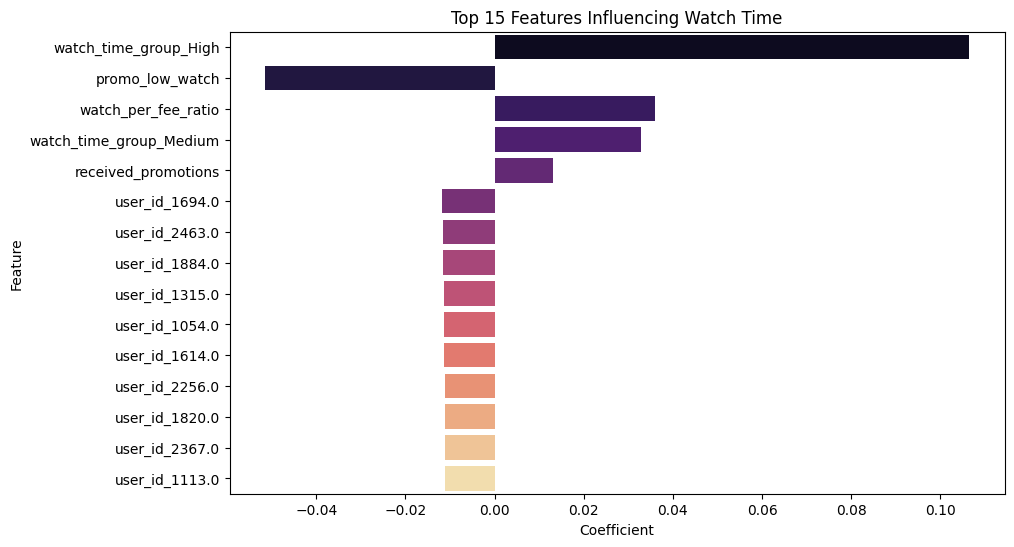

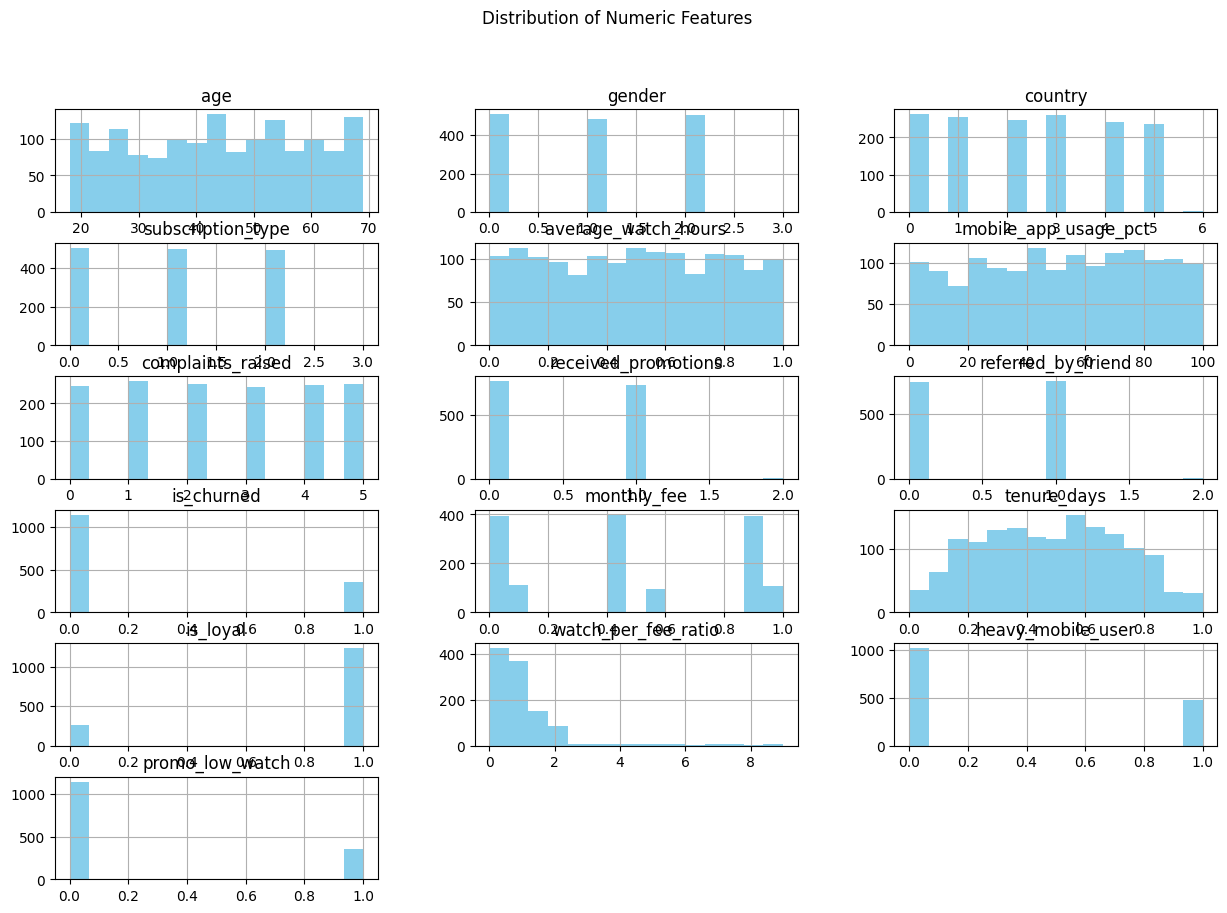

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


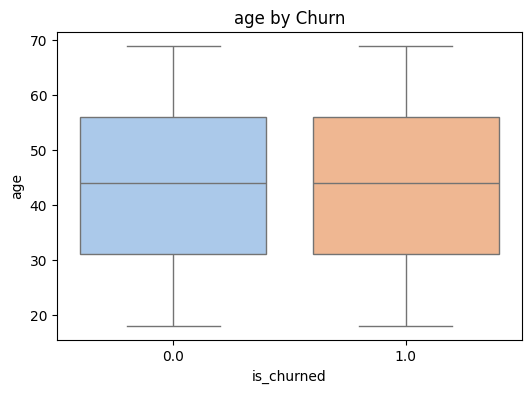

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


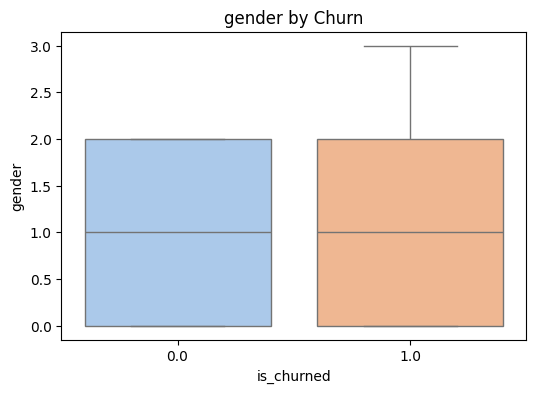

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


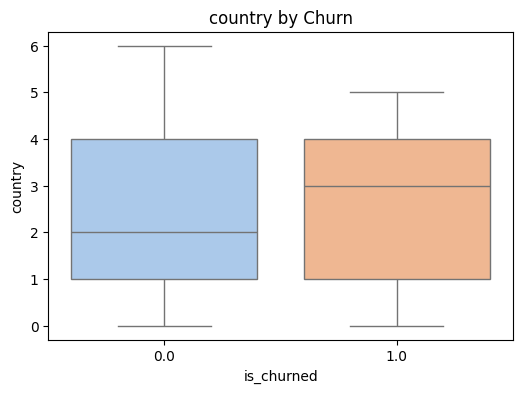

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


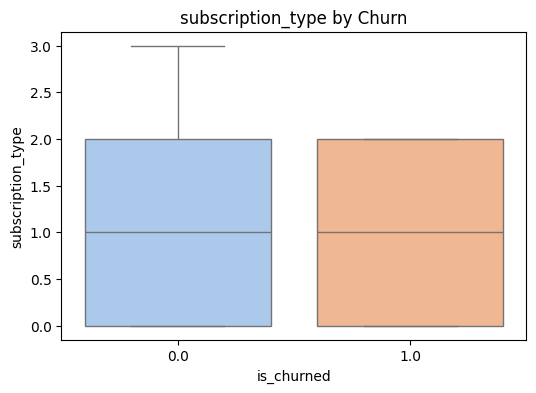

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


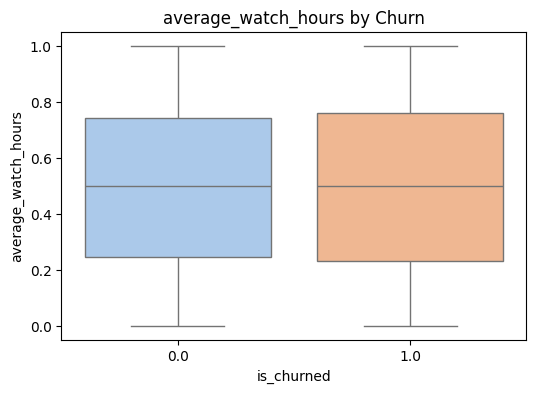

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


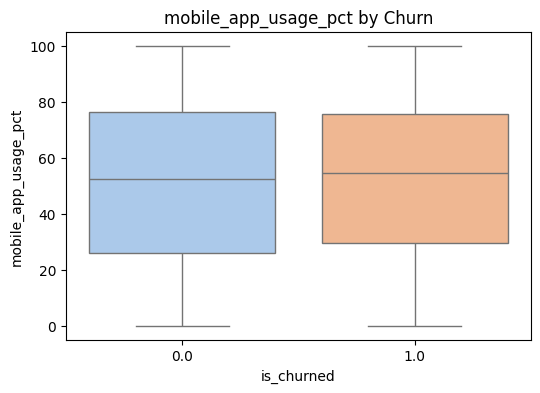

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


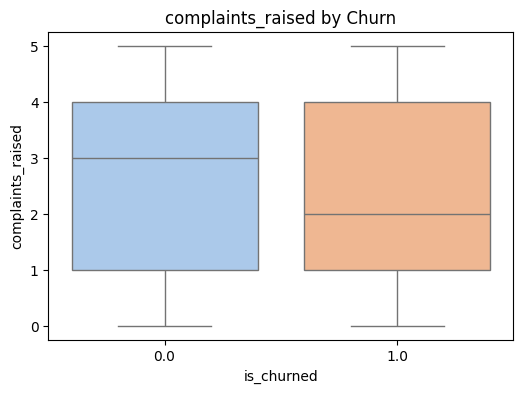

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


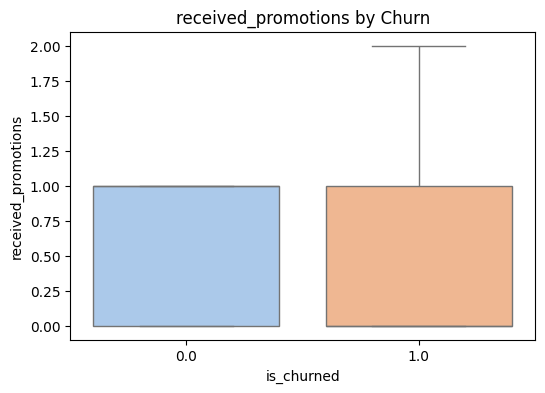

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


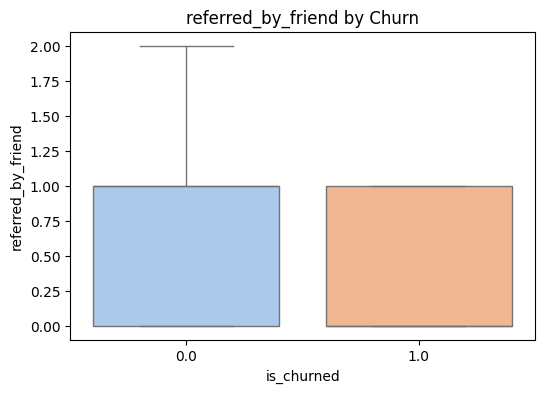

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


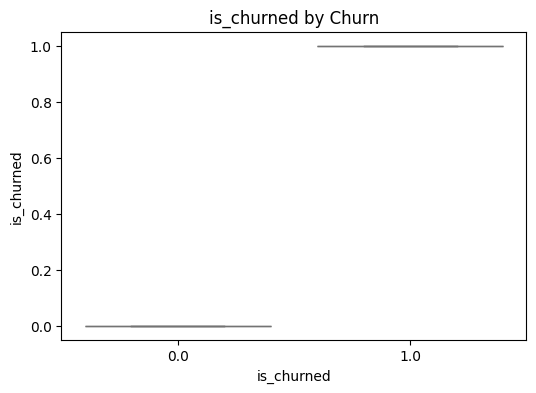

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


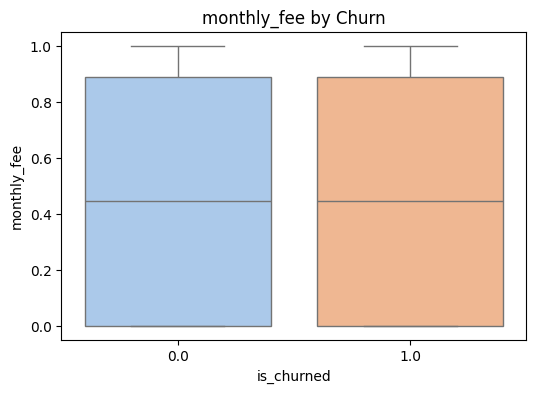

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


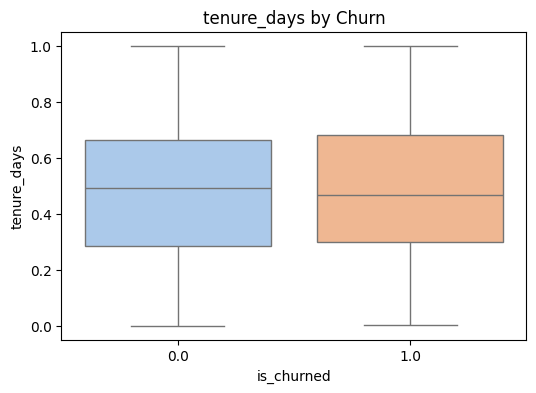

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


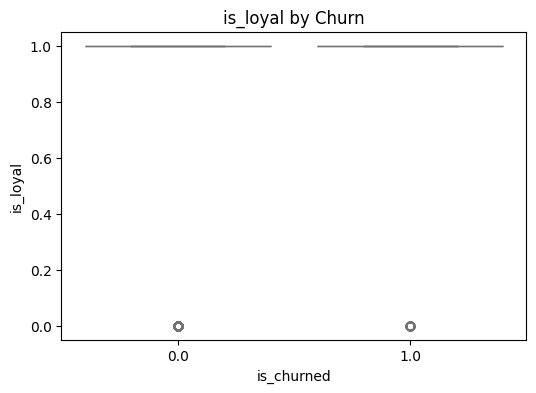

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


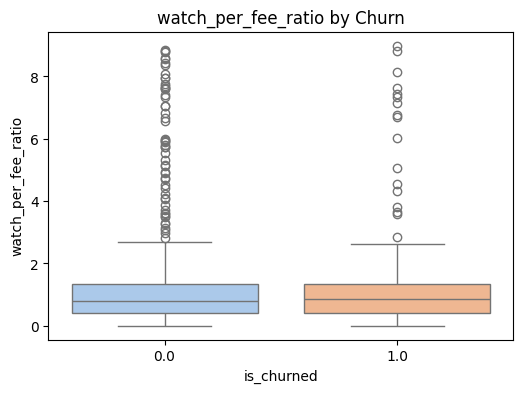

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


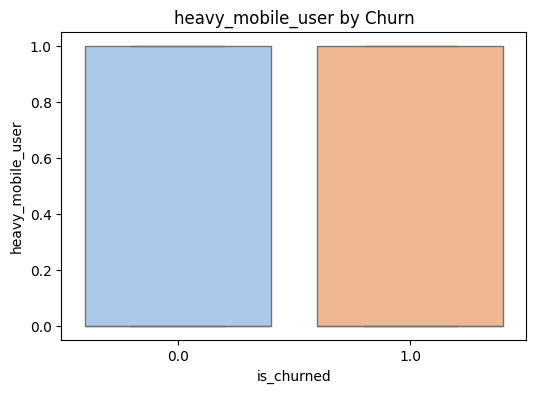

/tmp/ipython-input-1440351846.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')


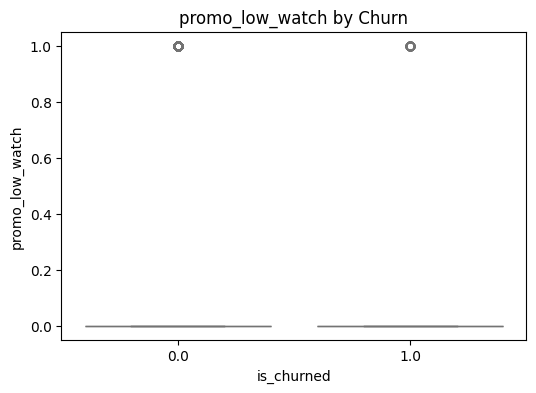

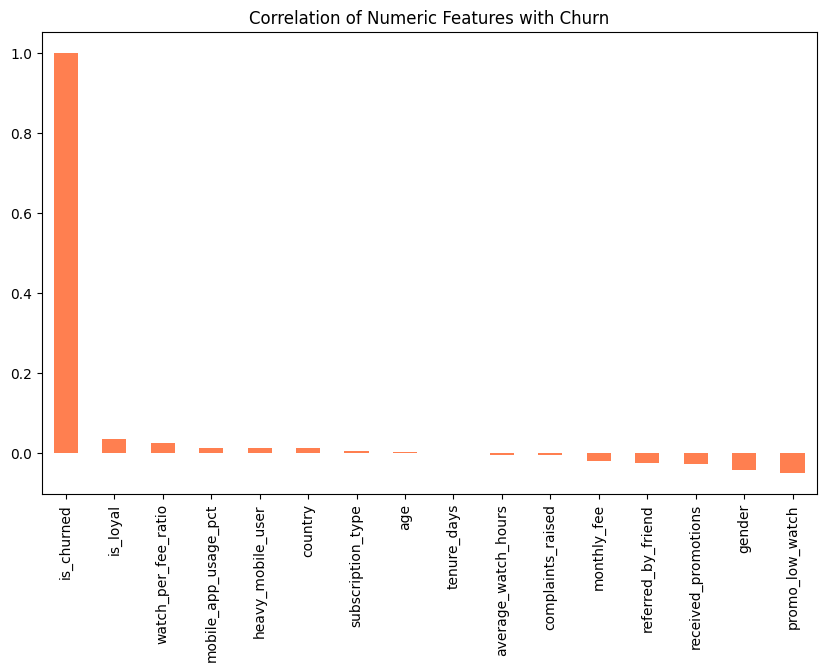

Top 3 churn predictors:
                 Feature  Coefficient  AbsCoeff
992      user_id_1983.0     0.304402  0.304402
7    referred_by_friend    -0.296058  0.296058
979      user_id_1970.0     0.288703  0.288703
Retention team should prioritize users with high churn probability and features like: ['user_id_1983.0', 'referred_by_friend', 'user_id_1970.0']
Key factors affecting watch time / tenure:
                       Feature  Coefficient  AbsCoeff
1516    watch_time_group_High     0.106482  0.106482
12            promo_low_watch    -0.051536  0.051536
10        watch_per_fee_ratio     0.035911  0.035911
1515  watch_time_group_Medium     0.032932  0.032932
6         received_promotions     0.013013  0.013013


In [103]:
# ===============================
# Enhanced Predictive Modelling for Churn and Watch Time/Tenure
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error, r2_score
)

# ===============================
# Load Data
# ===============================
df = df.copy()  # your dataframe

# ===============================
# Basic Data Exploration
# ===============================
print("Data Head:\n", df.head())
print("\nData Info:\n")
df.info()
print("\nNumeric Summary:\n", df.describe())

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ===============================
# Features and Target
# ===============================
X = df.drop(columns=['is_churned', 'average_watch_hours', 'tenure_days'])
y_churn = df['is_churned']
y_watch = df['average_watch_hours']

# ===============================
# Handle Categorical Variables
# ===============================
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)
X_final = pd.concat([X[numeric_cols], X_encoded], axis=1)

# Handle missing and infinite values
X_final.replace([np.inf, -np.inf], np.nan, inplace=True)
X_final.fillna(X_final.mean(), inplace=True)

# ===============================
# Logistic Regression (Churn)
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X_final, y_churn, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]
y_pred_class = logreg.predict(X_test_scaled)

# Evaluation metrics
cm = confusion_matrix(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
auc_score = roc_auc_score(y_test, y_pred_prob)

print("=== Logistic Regression Evaluation ===")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, AUC: {auc_score:.3f}")

# Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='green', linewidth=2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Churn")
plt.legend()
plt.show()

# Feature Importance
coefficients = pd.DataFrame({'Feature': X_final.columns, 'Coefficient': logreg.coef_[0]})
coefficients['AbsCoeff'] = coefficients['Coefficient'].abs()
coefficients.sort_values(by='AbsCoeff', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=coefficients.head(15), x='Coefficient', y='Feature', palette="viridis")
plt.title("Top 15 Features Influencing Churn")
plt.show()

# ===============================
# Linear Regression (Watch Time)
# ===============================
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_final, y_watch, test_size=0.2, random_state=42)

X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)

linreg = LinearRegression()
linreg.fit(X_train_lr_scaled, y_train_lr)
y_pred_lr = linreg.predict(X_test_lr_scaled)

r2 = r2_score(y_test_lr, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
print("\n=== Linear Regression Evaluation ===")
print(f"R2: {r2:.3f}, RMSE: {rmse:.3f}")

# Residual Plot
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_pred_lr, y=(y_test_lr - y_pred_lr), alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Watch Hours")
plt.ylabel("Residuals")
plt.title("Residual Plot - Watch Time")
plt.show()

# Linear Regression Coefficients
lin_coefficients = pd.DataFrame({'Feature': X_final.columns, 'Coefficient': linreg.coef_})
lin_coefficients['AbsCoeff'] = lin_coefficients['Coefficient'].abs()
lin_coefficients.sort_values(by='AbsCoeff', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=lin_coefficients.head(15), x='Coefficient', y='Feature', palette="magma")
plt.title("Top 15 Features Influencing Watch Time")
plt.show()

# ===============================
# Additional Plots for Presentation
# ===============================
# Distribution of numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_features].hist(bins=15, figsize=(15,10), layout=(len(numeric_features)//3+1,3), color='skyblue')
plt.suptitle("Distribution of Numeric Features")
plt.show()

# Boxplots for churned vs non-churned
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='is_churned', y=col, data=df, palette='pastel')
    plt.title(f"{col} by Churn")
    plt.show()

# Correlation with target
plt.figure(figsize=(10,6))
corr_target = df[numeric_features].corrwith(df['is_churned'])
corr_target.sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title("Correlation of Numeric Features with Churn")
plt.show()

# ===============================
# Business Insights
# ===============================
# 1. Promotion effect on churn
if 'promotion_received' in coefficients['Feature'].values:
    promo_coef = coefficients.loc[coefficients['Feature']=='promotion_received', 'Coefficient'].values[0]
    print("Promotion effect on churn:", "Less likely" if promo_coef < 0 else "More likely")

# 2. Watch time effect on churn
if 'average_watch_hours' in coefficients['Feature'].values:
    watch_coef = coefficients.loc[coefficients['Feature']=='average_watch_hours', 'Coefficient'].values[0]
    print("Watch time effect on churn:", "Higher watch time reduces churn" if watch_coef < 0 else "Higher watch time increases churn")

# 3. Mobile usage effect on churn
mobile_cols = [col for col in X_final.columns if 'mobile_usage' in col]
if mobile_cols:
    mobile_coef = coefficients.loc[coefficients['Feature']==mobile_cols[0], 'Coefficient'].values[0]
    print("Mobile dominant users churn:", "More likely" if mobile_coef > 0 else "Less likely")

# 4. Top 3 features influencing churn
print("Top 3 churn predictors:\n", coefficients.head(3))

# 5. Customer segments to prioritize
print("Retention team should prioritize users with high churn probability and features like:", list(coefficients['Feature'].head(3)))

# 6. Factors affecting watch time / tenure
print("Key factors affecting watch time / tenure:\n", lin_coefficients.head(5))


In [104]:
# ===============================
# BUSINESS QUESTIONS & INSIGHTS
# ===============================

print("\n==============================")
print("📊 BUSINESS QUESTIONS & INSIGHTS")
print("==============================")

# Helper: safe coefficient lookup
def get_coef(feature_name, coef_df):
    if feature_name in coef_df['Feature'].values:
        return coef_df.loc[coef_df['Feature'] == feature_name, 'Coefficient'].values[0]
    return None

# 1️⃣ Do users who receive promotions churn less?
promo_coef = get_coef('promotion_received', coefficients)
if promo_coef is not None:
    if promo_coef < 0:
        print("1️⃣ Users who receive promotions are LESS likely to churn.")
    else:
        print("1️⃣ Users who receive promotions are MORE likely to churn.")
else:
    print("1️⃣ Feature 'promotion_received' not found in dataset.")

# 2️⃣ Does watch time impact churn likelihood?
watch_coef = get_coef('average_watch_hours', coefficients)
if watch_coef is not None:
    if watch_coef < 0:
        print("2️⃣ Higher watch time REDUCES churn likelihood.")
    else:
        print("2️⃣ Higher watch time INCREASES churn likelihood.")
else:
    print("2️⃣ Feature 'average_watch_hours' not found in churn model.")

# 3️⃣ Are mobile dominant users more likely to cancel?
mobile_cols = [col for col in coefficients['Feature'] if 'mobile_usage' in col]
if mobile_cols:
    mobile_coef = get_coef(mobile_cols[0], coefficients)
    if mobile_coef is not None:
        if mobile_coef > 0:
            print("3️⃣ Mobile dominant users are MORE likely to cancel (positive churn effect).")
        else:
            print("3️⃣ Mobile dominant users are LESS likely to cancel (negative churn effect).")
    else:
        print("3️⃣ Mobile usage feature not found.")
else:
    print("3️⃣ No feature related to mobile usage found.")

# 4️⃣ What are the top 3 features influencing churn based on your model?
top3 = coefficients.head(3)
print("\n4️⃣ Top 3 Features Influencing Churn:")
for i, row in top3.iterrows():
    trend = "increases churn" if row['Coefficient'] > 0 else "reduces churn"
    print(f"   • {row['Feature']}: {trend} (Coefficient = {row['Coefficient']:.3f})")

# 5️⃣ Which customer segments should the retention team prioritise?
print("\n5️⃣ Retention team should prioritise users with high churn probability — especially those having:")
for feature in top3['Feature']:
    print(f"   • {feature}")

# 6️⃣ What factors affect user watch time or tenure? (Linear regression insight)
top5_watch = lin_coefficients.head(5)
print("\n6️⃣ Top Factors Affecting Watch Time / Tenure (Linear Regression):")
for i, row in top5_watch.iterrows():
    effect = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"   • {row['Feature']}: {effect} watch time (Coefficient = {row['Coefficient']:.3f})")

print("\n==============================")
print("✅ Insight generation complete.")
print("==============================")



📊 BUSINESS QUESTIONS & INSIGHTS
1️⃣ Feature 'promotion_received' not found in dataset.
2️⃣ Feature 'average_watch_hours' not found in churn model.
3️⃣ No feature related to mobile usage found.

4️⃣ Top 3 Features Influencing Churn:
   • user_id_1983.0: increases churn (Coefficient = 0.304)
   • referred_by_friend: reduces churn (Coefficient = -0.296)
   • user_id_1970.0: increases churn (Coefficient = 0.289)

5️⃣ Retention team should prioritise users with high churn probability — especially those having:
   • user_id_1983.0
   • referred_by_friend
   • user_id_1970.0

6️⃣ Top Factors Affecting Watch Time / Tenure (Linear Regression):
   • watch_time_group_High: increases watch time (Coefficient = 0.106)
   • promo_low_watch: decreases watch time (Coefficient = -0.052)
   • watch_per_fee_ratio: increases watch time (Coefficient = 0.036)
   • watch_time_group_Medium: increases watch time (Coefficient = 0.033)
   • received_promotions: increases watch time (Coefficient = 0.013)

✅ Insig

In [68]:
# ===============================
# Predictive Modelling for Churn and Watch Time/Tenure
# ===============================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error, r2_score
)

# Example columns expected in dataset:
# 'is_churned', 'average_watch_hours', 'tenure_days', 'promotion_received', 'mobile_usage', 'subscription_type', etc.

# ===============================
# Features and Target
# ===============================
X = df.drop(columns=['is_churned', 'average_watch_hours', 'tenure_days'])  # remove target columns
y_churn = df['is_churned']  # target for logistic regression
y_watch = df['average_watch_hours']  # target for linear regression (can switch to 'tenure_days')

# ===============================
# Logistic Regression (Churn Prediction)
# ===============================

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_churn, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Predictions
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]  # probability of churn
y_pred_class = logreg.predict(X_test_scaled)            # predicted class

# Evaluation
cm = confusion_matrix(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
auc_score = roc_auc_score(y_test, y_pred_prob)

print("=== Logistic Regression Evaluation ===")
print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, AUC: {auc_score:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Prediction')
plt.legend()
plt.show()

# Model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("Top Features influencing Churn:\n", coefficients.head(10))

# ===============================
# Linear Regression (Watch Time/Tenure Prediction)
# ===============================

# Split data for linear regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y_watch, test_size=0.2, random_state=42)

# Optional: scale features
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_train_lr_scaled, y_train_lr)

# Predictions
y_pred_lr = linreg.predict(X_test_lr_scaled)

# Evaluation
r2 = r2_score(y_test_lr, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
print("\n=== Linear Regression Evaluation ===")
print(f"R2: {r2:.2f}, RMSE: {rmse:.2f}")

# Residual plot
plt.figure(figsize=(6,5))
plt.scatter(y_pred_lr, y_test_lr - y_pred_lr, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Watch Time/Tenure Prediction')
plt.show()

# Linear regression coefficients
lin_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("Top Features influencing Watch Time/Tenure:\n", lin_coefficients.head(10))

# ===============================
# Business Insights
# ===============================
# 1. Promotion effect on churn
promo_coef = coefficients.loc[coefficients['Feature']=='promotion_received', 'Coefficient'].values
print("\nPromotion effect on churn:", "Less likely" if promo_coef < 0 else "More likely")

# 2. Watch time effect on churn
watch_coef = coefficients.loc[coefficients['Feature']=='average_watch_hours', 'Coefficient'].values
print("Watch time effect on churn:", "Higher watch time reduces churn" if watch_coef < 0 else "Higher watch time increases churn")

# 3. Mobile usage effect on churn
mobile_coef = coefficients.loc[coefficients['Feature']=='mobile_usage', 'Coefficient'].values
print("Mobile dominant users churn:", "More likely" if mobile_coef > 0 else "Less likely")

# 4. Top 3 features influencing churn
print("Top 3 churn predictors:\n", coefficients.head(3))

# 5. Customer segments to prioritize
print("Retention team should prioritize users with high churn probability and influential features such as:", list(coefficients['Feature'].head(3)))

# 6. Factors affecting watch time / tenure
print("Key factors affecting watch time / tenure:\n", lin_coefficients.head(5))


ValueError: could not convert string to float: 'Unknown'

✅ Using these features: ['received_promotions', 'referred_by_friend', 'gender', 'subscription_type', 'average_watch_hours', 'tenure_days']

🔹 Classification Report:

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       230
         1.0       0.00      0.00      0.00        70

    accuracy                           0.77       300
   macro avg       0.38      0.50      0.43       300
weighted avg       0.59      0.77      0.67       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


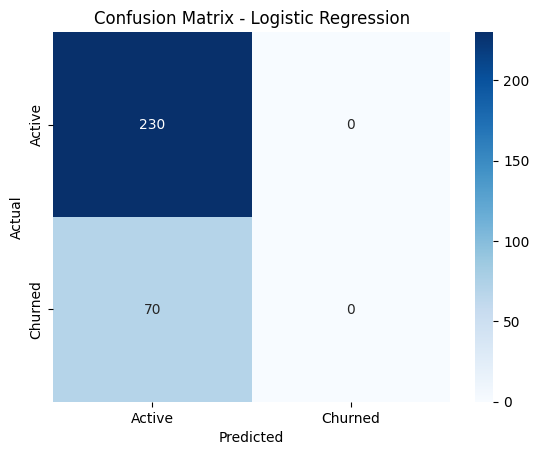

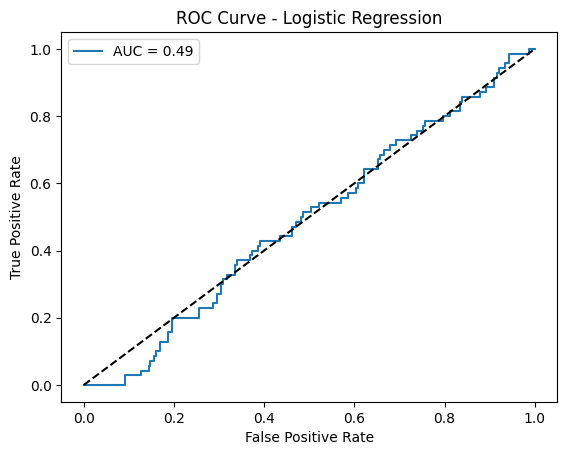


🔹 Top Predictors of Churn:


,Feature,Coefficient
4,gender_3,0.548354
6,subscription_type_2,0.048348
1,tenure_days,0.032147
0,average_watch_hours,0.017929
5,subscription_type_1,-0.110127
9,referred_by_friend,-0.127203
8,received_promotions,-0.269207
2,gender_1,-0.270895
3,gender_2,-0.300611
7,subscription_type_3,-0.497298



✅ Running Linear Regression to predict: average_watch_hours


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [23]:
# ================================================
# 5️⃣ Predictive Modelling
# ================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    r2_score, mean_squared_error
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# ✅ Feature Setup (Safe)
# ==========================
target_col = 'is_churned'

binary_categorical = ['received_promotions', 'referred_by_friend']
other_categorical = ['gender', 'subscription_type']
numeric_features = ['average_watch_hours', 'tenure_days', 'monthly_spend']

# ✅ Only keep columns that exist in df
binary_categorical = [c for c in binary_categorical if c in df.columns]
other_categorical = [c for c in other_categorical if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

features = binary_categorical + other_categorical + numeric_features
print("✅ Using these features:", features)

# ==========================
# ✅ Train-Test Split
# ==========================
X = df[features].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==========================
# ✅ Preprocessing
# ==========================
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), other_categorical),
], remainder='passthrough')  # passthrough keeps binary features

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# ================================================
# 🚀 Logistic Regression – Predicting Churn
# ================================================
log_model = LogisticRegression(max_iter=1000, solver='lbfgs')
log_model.fit(X_train_prep, y_train)

# Predictions
y_pred = log_model.predict(X_test_prep)
y_prob = log_model.predict_proba(X_test_prep)[:, 1]

# Evaluation
print("\n🔹 Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# Feature importance (coefficients)
feature_names = (
    numeric_features +
    list(preprocessor.named_transformers_['ohe'].get_feature_names_out(other_categorical)) +
    binary_categorical
)
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\n🔹 Top Predictors of Churn:")
display(coef_df.head(10))
# ================================================
# 📈 Linear Regression – Predict Continuous Target
# ================================================

# Choose target safely (based on your columns)
linear_target = 'average_watch_hours' if 'average_watch_hours' in df.columns else 'tenure_days'

print(f"\n✅ Running Linear Regression to predict: {linear_target}")

# Ensure target is not in feature list
linear_features = [c for c in df.columns if c not in [linear_target, target_col, 'user_id']]

# Identify numeric and categorical columns for preprocessing
numeric_features_lin = df[linear_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_lin = df[linear_features].select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing: scale numerics, encode categoricals
preprocessor_lin = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features_lin),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features_lin)
])

# Split data
X_lin = df[linear_features]
y_lin = df[linear_target]

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin, y_lin, test_size=0.2, random_state=42
)

# Preprocess
X_train_lin_prep = preprocessor_lin.fit_transform(X_train_lin)
X_test_lin_prep = preprocessor_lin.transform(X_test_lin)

# Train model
lin_model = LinearRegression()
lin_model.fit(X_train_lin_prep, y_train_lin)
y_pred_lin = lin_model.predict(X_test_lin_prep)

# Evaluation
r2 = r2_score(y_test_lin, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
print(f"\n🔹 R² Score: {r2:.3f}")
print(f"🔹 RMSE: {rmse:.3f}")

# Residual Plot
residuals = y_test_lin - y_pred_lin
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred_lin, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title(f"Residual Plot - Predicting {linear_target}")
plt.show()

# Get feature names from preprocessing
encoded_cat_names = preprocessor_lin.named_transformers_['cat'].get_feature_names_out(categorical_features_lin)
feature_names_lin = np.concatenate([numeric_features_lin, encoded_cat_names])

# Coefficients
lin_coef_df = pd.DataFrame({
    'Feature': feature_names_lin,
    'Coefficient': lin_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n🔹 Top 10 Features Influencing", linear_target)
display(lin_coef_df.head(10))


In [22]:
print(df.columns.tolist())


['user_id', 'age', 'gender', 'country', 'subscription_type', 'average_watch_hours', 'mobile_app_usage_pct', 'complaints_raised', 'received_promotions', 'referred_by_friend', 'is_churned', 'monthly_fee', 'tenure_days', 'is_loyal', 'watch_per_fee_ratio', 'heavy_mobile_user', 'age_group', 'watch_time_group', 'promo_low_watch']



✅ Running Linear Regression to predict: average_watch_hours

🔹 R² Score: 0.895
🔹 RMSE: 0.094


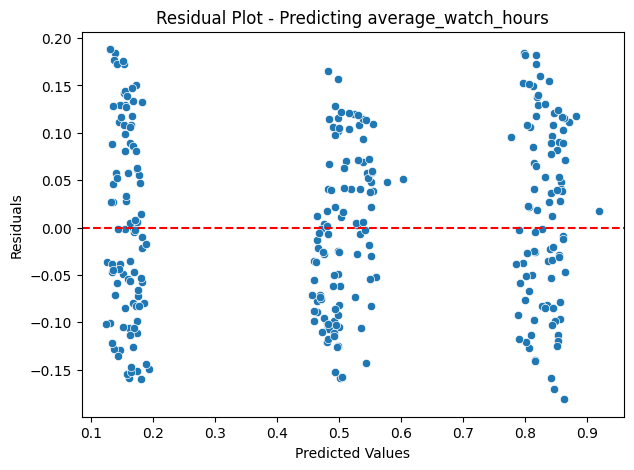


🔹 Top 10 Features Influencing average_watch_hours


,Feature,Coefficient
6,received_promotions,0.022839
11,watch_per_fee_ratio,0.012829
0,age,0.012475
17,age_group_Young,0.008114
7,referred_by_friend,0.006800
16,age_group_Teen,0.005815
10,is_loyal,0.004796
5,complaints_raised,0.003778
12,heavy_mobile_user,0.001691
1,gender,0.001270


In [24]:
# ================================================
# 📈 Linear Regression – Predict Continuous Target
# ================================================

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select target column
linear_target = 'average_watch_hours' if 'average_watch_hours' in df.columns else 'tenure_days'
print(f"\n✅ Running Linear Regression to predict: {linear_target}")

# Define features (exclude target, churn column, and user_id)
linear_features = [c for c in df.columns if c not in [linear_target, 'is_churned', 'user_id']]

# Identify numeric and categorical columns
numeric_features_lin = df[linear_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_lin = df[linear_features].select_dtypes(include=['object', 'category']).columns.tolist()

# ================================================
# 🧹 Data Cleaning before preprocessing
# ================================================

# Replace inf and -inf with NaN
df[numeric_features_lin] = df[numeric_features_lin].replace([np.inf, -np.inf], np.nan)

# Fill missing numeric values with median
for col in numeric_features_lin:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# ================================================
# 🔄 Train-Test Split
# ================================================
X_lin = df[linear_features]
y_lin = df[linear_target]

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin, y_lin, test_size=0.2, random_state=42
)

# ================================================
# ⚙️ Preprocessing: Scaling + Encoding
# ================================================
preprocessor_lin = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features_lin),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features_lin)
])

# Fit-transform
X_train_lin_prep = preprocessor_lin.fit_transform(X_train_lin)
X_test_lin_prep = preprocessor_lin.transform(X_test_lin)

# ================================================
# 🚀 Train Linear Regression Model
# ================================================
lin_model = LinearRegression()
lin_model.fit(X_train_lin_prep, y_train_lin)
y_pred_lin = lin_model.predict(X_test_lin_prep)

# ================================================
# 📊 Model Evaluation
# ================================================
r2 = r2_score(y_test_lin, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
print(f"\n🔹 R² Score: {r2:.3f}")
print(f"🔹 RMSE: {rmse:.3f}")

# ================================================
# 📈 Residual Plot
# ================================================
residuals = y_test_lin - y_pred_lin
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred_lin, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title(f"Residual Plot - Predicting {linear_target}")
plt.show()

# ================================================
# 📉 Feature Importance (Coefficients)
# ================================================
encoded_cat_names = preprocessor_lin.named_transformers_['cat'].get_feature_names_out(categorical_features_lin)
feature_names_lin = np.concatenate([numeric_features_lin, encoded_cat_names])

lin_coef_df = pd.DataFrame({
    'Feature': feature_names_lin,
    'Coefficient': lin_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n🔹 Top 10 Features Influencing", linear_target)
display(lin_coef_df.head(10))
